In [ ]:
!pip install catboost
!pip install lightgbm
!pip install category_encoders

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/content/Casestudy_Data.csv')
data.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56.0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57.0,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37.0,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,NaN,-36.4,4.857,5191.0,no


In [ ]:
numerical_features = data.select_dtypes(include=['number'])
categorical_features = data.select_dtypes(include=['object'])

In [ ]:
ordinal_features = ['job', 'education', 'housing']
nominal_features = ['marital', 'default', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

In [ ]:
from sklearn.impute import KNNImputer

class DataImputer:
    @staticmethod
    def impute_with_mode(data, columns_to_impute):
        for column in columns_to_impute:
            data[column] = data[column].replace('unknown', data[column].mode()[0])
        return data

    @staticmethod
    def impute_with_knn(X_train_encoded, X_test_encoded, name_mapping, n_neighbors=3):
        imputer = KNNImputer(n_neighbors=n_neighbors)

        columns_with_unknown = X_train_encoded.columns[X_train_encoded.isin(['unknown']).any()].tolist()

        for col in columns_with_unknown:
            label = name_mapping[col]['unknown']
            X_train_encoded[col] = X_train_encoded[col].replace(label, np.nan)
            X_test_encoded[col] = X_test_encoded[col].replace(label, np.nan)

        imputed_data_train = imputer.fit_transform(X_train_encoded)
        imputed_X_train = pd.DataFrame(imputed_data_train, columns=X_train_encoded.columns)

        imputed_data_test = imputer.transform(X_test_encoded)
        imputed_X_test = pd.DataFrame(imputed_data_test, columns=X_test_encoded.columns)

        return imputed_X_train, imputed_X_test

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import BinaryEncoder, TargetEncoder

class NominalEncoder:
    @staticmethod
    def perform_OHE(X_train, X_test, y_train, y_test, nominal_variables):
        ohe = OneHotEncoder()
        ohe_train_matrix = ohe.fit_transform(X_train[nominal_variables])
        ohe_col_names = ohe.get_feature_names_out().tolist()
        X_train_ohe = pd.DataFrame(ohe_train_matrix.toarray(), columns=ohe_col_names)

        X_train_copy = X_train.copy()
        X_train_copy.drop(columns=nominal_variables, inplace=True)
        X_train_ohe = pd.concat([X_train_copy.reset_index(drop=True), X_train_ohe.reset_index(drop=True)], axis=1)

        ohe_test_matrix = ohe.transform(X_test[nominal_variables])
        X_test_ohe = pd.DataFrame(ohe_test_matrix.toarray(), columns=ohe_col_names)

        X_test_copy = X_test.copy()
        X_test_copy.drop(columns=nominal_variables, inplace=True)
        X_test_ohe = pd.concat([X_test_copy.reset_index(drop=True), X_test_ohe.reset_index(drop=True)], axis=1)

        return X_train_ohe, X_test_ohe

    @staticmethod
    def perform_binary_encoding(X_train, X_test, y_train, y_test, nominal_variables):
        encoder_binary = BinaryEncoder(cols=nominal_variables, return_df=True)
        X_train_encoded = encoder_binary.fit_transform(X_train)
        X_test_encoded = encoder_binary.transform(X_test)
        return X_train_encoded, X_test_encoded

    @staticmethod
    def perform_target_encoding(X_train, X_test, y_train, y_test, nominal_variables):
        encoder_target = TargetEncoder(cols=nominal_variables)
        X_train[nominal_variables] = encoder_target.fit_transform(X_train[nominal_variables], y_train)
        X_test[nominal_variables] = encoder_target.transform(X_test[nominal_variables], y_test)
        return X_train, X_test

In [ ]:
class OrdinalEncoder:
    @staticmethod
    def perform_label_encoding(X_train, X_test, ordinal_variables):
        le = LabelEncoder()
        le_name_mapping = {}
        for col in ordinal_variables:
            X_train[col] = le.fit_transform(X_train[col])
            X_test[col] = le.transform(X_test[col])
            le_name_mapping[col] = dict(zip(le.classes_, le.transform(le.classes_)))
        return X_train, X_test, le_name_mapping

In [ ]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler

class Resampler:
    @staticmethod
    def undersample(X_train, y_train):
        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)

        train_data = pd.concat([X_train, y_train], axis=1)

        majority_class = train_data[train_data['y'] == 0]
        minority_class = train_data[train_data['y'] == 1]

        majority_downsampled = resample(majority_class,
                                        replace=False,
                                        n_samples=len(minority_class),
                                        random_state=42)

        undersampled_data = pd.concat([minority_class.reset_index(drop=True), majority_downsampled.reset_index(drop=True)])

        undersampled_X_train = undersampled_data.drop(columns=['y'])
        undersampled_y_train = undersampled_data['y']
        return undersampled_X_train, undersampled_y_train

    @staticmethod
    def oversample(X_train, y_train):
        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)

        train_data = pd.concat([X_train, y_train], axis=1)

        majority_class = train_data[train_data['y'] == 0]
        minority_class = train_data[train_data['y'] == 1]

        minority_upsampled = resample(minority_class,
                                      replace=True,
                                      n_samples=len(majority_class),
                                      random_state=42)

        oversampled_data = pd.concat([majority_class.reset_index(drop=True), minority_upsampled.reset_index(drop=True)])

        oversampled_X_train = oversampled_data.drop(columns=['y'])
        oversampled_y_train = oversampled_data['y']
        return oversampled_X_train, oversampled_y_train

    @staticmethod
    def smote(X_train, y_train):
        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        smote = SMOTE(random_state=42)
        X_smote, y_smote = smote.fit_resample(X_train, y_train)
        return X_smote, y_smote

    @staticmethod
    def tomek_links(X_train, y_train):
        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        tl = TomekLinks()
        X_tl, y_tl = tl.fit_resample(X_train, y_train)
        return X_tl, y_tl

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class DataScaler:
    @staticmethod
    def perform_standard_scaling(X_train, X_test):
        standard_scaler = StandardScaler()
        scaled_X_train = pd.DataFrame(standard_scaler.fit_transform(X_train), columns=X_train.columns)
        scaled_X_test = pd.DataFrame(standard_scaler.transform(X_test), columns=X_test.columns)
        return scaled_X_train, scaled_X_test

    @staticmethod
    def perform_min_max_scaling(X_train, X_test):
        min_max_scaler = MinMaxScaler()
        scaled_X_train = pd.DataFrame(min_max_scaler.fit_transform(X_train), columns=X_train.columns)
        scaled_X_test = pd.DataFrame(min_max_scaler.transform(X_test), columns=X_test.columns)
        return scaled_X_train, scaled_X_test

In [ ]:
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

class ClassifierTrainer:
    @staticmethod
    def train_decision_tree(X_train, y_train):
        clf = DecisionTreeClassifier()
        clf.fit(X_train, y_train)
        return clf

    @staticmethod
    def train_random_forest(X_train, y_train):
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)
        return clf

    @staticmethod
    def train_xgboost_classifier(X_train, y_train):
        clf = xgb.XGBClassifier(verbose=False)
        clf.fit(X_train, y_train)
        return clf

    @staticmethod
    def train_catboost_classifier(X_train, y_train):
        clf = cb.CatBoostClassifier()
        clf.fit(X_train, y_train, verbose=False)
        return clf

    @staticmethod
    def train_lightgbm_classifier(X_train, X_test, y_train, y_test):
        params = {
            'boosting_type': 'gbdt',    # Gradient Boosting Decision Tree
            'objective': 'binary',      # Binary classification task
            'metric': 'binary_error',   # Metric to be used
            'num_leaves': 31,           # Maximum number of leaves in one tree
            'learning_rate': 0.05,      # Learning rate of gradient boosting
            'feature_fraction': 0.9,    # Percentage of features to use in each iteration
            'bagging_fraction': 0.8,    # Percentage of data to use in each iteration
            'bagging_freq': 5,          # Frequency for bagging
            'verbose': 0,               # Verbosity level
            'early_stopping_rounds': 10 # Earlty stopping rounds
        }

        # Creating LightGBM dataset
        train_data = lgb.Dataset(X_train, label=y_train)
        test_data = lgb.Dataset(X_test, label=y_test)

        # Training the model
        lgb_model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])

        return lgb_model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from tqdm import tqdm
import time

# Start timer
start_time = time.time()

# Impute Unknown values with mode
mode_impute_cols = ['marital', 'loan', 'default']

imputed_data = DataImputer.impute_with_mode(data, mode_impute_cols)

# Train Test Split
X = imputed_data.drop(columns='y')
y = imputed_data['y'].map({'yes': 1, 'no': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y,
                                                    random_state=42,
                                                    shuffle=True)

# Define possible options for each step
encodings = [('OHE', NominalEncoder.perform_OHE),
             ('Binary', NominalEncoder.perform_binary_encoding),
             ('Target', NominalEncoder.perform_target_encoding)]

samplings = [('None', lambda x_train, x_test: (x_train, x_test)),
             ('Undersample', Resampler.undersample),
             ('Oversample', Resampler.oversample),
             ('SMOTE', Resampler.smote),
             ('TomekLinks', Resampler.tomek_links)]

scalings = [('None', lambda x_train, x_test: (x_train, x_test)),
            ('StandardScaler', DataScaler.perform_standard_scaling),
            ('MinMaxScaler', DataScaler.perform_min_max_scaling)]

models = [('DecisionTree', ClassifierTrainer.train_decision_tree),
          ('RandomForest', ClassifierTrainer.train_random_forest),
          ('XGBoost', ClassifierTrainer.train_xgboost_classifier),
          ('CatBoost', ClassifierTrainer.train_catboost_classifier)]

# Initialize a DataFrame to track all combinations and their metrics
results_df = pd.DataFrame(columns=['Encoding', 'Sampling', 'Scaling', 'Model',
                                   'Precision Class 0', 'Precision Class 1',
                                   'Recall Class 0', 'Recall Class 1',
                                   'F1 Score Class 0', 'F1 Score Class 1',
                                   'AUC Score', 'Overall Accuracy'])

# Calculate total number of combinations for progress bar
total_combinations = len(encodings) * len(samplings) * len(scalings) * len(models)

# Initialize progress bar
with tqdm(total=total_combinations, desc="Processing Combinations") as pbar:
    # Iterate through all combinations
    for encoding_name, encoding_func in encodings:
        X_train_encoded, X_test_encoded = encoding_func(X_train, X_test, y_train, y_test, nominal_features)
        X_train_encoded, X_test_encoded, name_mapping = OrdinalEncoder.perform_label_encoding(X_train_encoded, X_test_encoded, ordinal_features)

        imputed_X_train, imputed_X_test = DataImputer.impute_with_knn(X_train_encoded, X_test_encoded, name_mapping)

        for sampling_name, sampling_func in samplings:
            X_sampled, y_sampled = sampling_func(imputed_X_train, y_train)

            for scaling_name, scaling_func in scalings:
                scaled_X_train, scaled_X_test = scaling_func(X_sampled, imputed_X_test)

                for model_name, model_func in models:
                    model = model_func(scaled_X_train, y_sampled)
                    y_pred = model.predict(scaled_X_test)
                    accuracy = accuracy_score(y_test, y_pred)
                    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
                    auc_score = roc_auc_score(y_test, y_pred)

                    # Store the results in the DataFrame
                    results_df = results_df.append({
                        'Encoding': encoding_name,
                        'Sampling': sampling_name,
                        'Scaling': scaling_name,
                        'Model': model_name,
                        'Precision Class 0': precision[0],
                        'Precision Class 1': precision[1],
                        'Recall Class 0': recall[0],
                        'Recall Class 1': recall[1],
                        'F1 Score Class 0': f1[0],
                        'F1 Score Class 1': f1[1],
                        'AUC Score' : auc_score,
                        'Overall Accuracy': accuracy
                    }, ignore_index=True)

                    # Update progress bar
                    pbar.update(1)

# Calculate and print time taken
end_time = time.time()
time_taken = end_time - start_time
print(f"\nTime taken: {time_taken:.2f} seconds")

Processing Combinations: 100%|██████████| 180/180 [18:41<00:00,  6.23s/it]


Time taken: 1122.00 seconds


In [ ]:
# Save results to excel
results_df.to_csv('modeling_results.csv')

In [ ]:
results_df.sort_values(by=['AUC Score', 'F1 Score Class 1'], ascending=False)

In [ ]:
results_df.sort_values(by=['F1 Score Class 1', 'AUC Score'], ascending=False)

Note:

1. If the bank has money, minimizing false negatives > minimising false positives

2. If the bank does not has money.
minimizing false positives > minimizing false negatives


Minizing false positives -> precision

Minizing false negatives -> recall

Note: Assuming our bank has money and wantes to reduce false negatives!

In [ ]:
subs_recall = results_df.sort_values(by='Recall Class 1', ascending=False)
subs_recall.head()

,Encoding,Sampling,Scaling,Model,Precision Class 0,Precision Class 1,Recall Class 0,Recall Class 1,F1 Score Class 0,F1 Score Class 1,AUC Score,Overall Accuracy
139,Target,Undersample,StandardScaler,CatBoost,0.992171,0.444164,0.849521,0.947198,0.915322,0.604747,0.898360,0.860524
135,Target,Undersample,None,CatBoost,0.992171,0.444164,0.849521,0.947198,0.915322,0.604747,0.898360,0.860524
19,OHE,Undersample,StandardScaler,CatBoost,0.991531,0.441919,0.848837,0.942888,0.914652,0.601788,0.895863,0.859432
143,Target,Undersample,MinMaxScaler,CatBoost,0.991546,0.444388,0.850342,0.942888,0.915531,0.604073,0.896615,0.860767
15,OHE,Undersample,None,CatBoost,0.991531,0.441919,0.848837,0.942888,0.914652,0.601788,0.895863,0.859432


In [ ]:
subs_precision = results_df.sort_values(by='Precision Class 1', ascending=False)
subs_precision.head()

,Encoding,Sampling,Scaling,Model,Precision Class 0,Precision Class 1,Recall Class 0,Recall Class 1,F1 Score Class 0,F1 Score Class 1,AUC Score,Overall Accuracy
61,Binary,None,None,RandomForest,0.940071,0.699558,0.972093,0.511853,0.955814,0.591164,0.741973,0.920248
69,Binary,None,MinMaxScaler,RandomForest,0.940172,0.696925,0.971683,0.512931,0.955668,0.590937,0.742307,0.920005
65,Binary,None,StandardScaler,RandomForest,0.939915,0.695015,0.971546,0.510776,0.955469,0.588820,0.741161,0.919641
5,OHE,None,StandardScaler,RandomForest,0.939246,0.686676,0.970725,0.505388,0.954726,0.582247,0.738056,0.918305
9,OHE,None,MinMaxScaler,RandomForest,0.939229,0.684672,0.970451,0.505388,0.954585,0.581525,0.737920,0.918063


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
results = pd.read_csv('/content/modeling_results.csv', index_col=0)

In [2]:
results

,Encoding,Sampling,Scaling,Model,Precision Class 0,Precision Class 1,Recall Class 0,Recall Class 1,F1 Score Class 0,F1 Score Class 1,AUC Score,Overall Accuracy
0,OHE,None,None,DecisionTree,0.939536,0.507804,0.935294,0.525862,0.937410,0.516675,0.730578,0.889172
1,OHE,None,None,RandomForest,0.939346,0.684134,0.970315,0.506466,0.954579,0.582043,0.738390,0.918063
2,OHE,None,None,XGBoost,0.946219,0.645910,0.960328,0.570043,0.953222,0.605610,0.765186,0.916363
3,OHE,None,None,CatBoost,0.945979,0.674807,0.965390,0.565733,0.955586,0.615475,0.765561,0.920369
4,OHE,None,StandardScaler,DecisionTree,0.938912,0.514408,0.937756,0.519397,0.938334,0.516890,0.728577,0.890629
...,...,...,...,...,...,...,...,...,...,...,...,...
175,Target,TomekLinks,StandardScaler,CatBoost,0.956015,0.645745,0.954446,0.654095,0.955230,0.649893,0.804270,0.920612
176,Target,TomekLinks,MinMaxScaler,DecisionTree,0.945818,0.501393,0.926539,0.581897,0.936079,0.538653,0.754218,0.887715
177,Target,TomekLinks,MinMaxScaler,RandomForest,0.951233,0.635452,0.955267,0.614224,0.953246,0.624658,0.784745,0.916849
178,Target,TomekLinks,MinMaxScaler,XGBoost,0.957163,0.630879,0.950616,0.664871,0.953878,0.647429,0.807743,0.918427


In [3]:
precision_results = results[results['Precision Class 1'] > results['Precision Class 1'].median()]

recall_results = results[results['Recall Class 1'] > results['Recall Class 1'].median()]

auc_results = results[results['AUC Score'] > results['AUC Score'].median()]

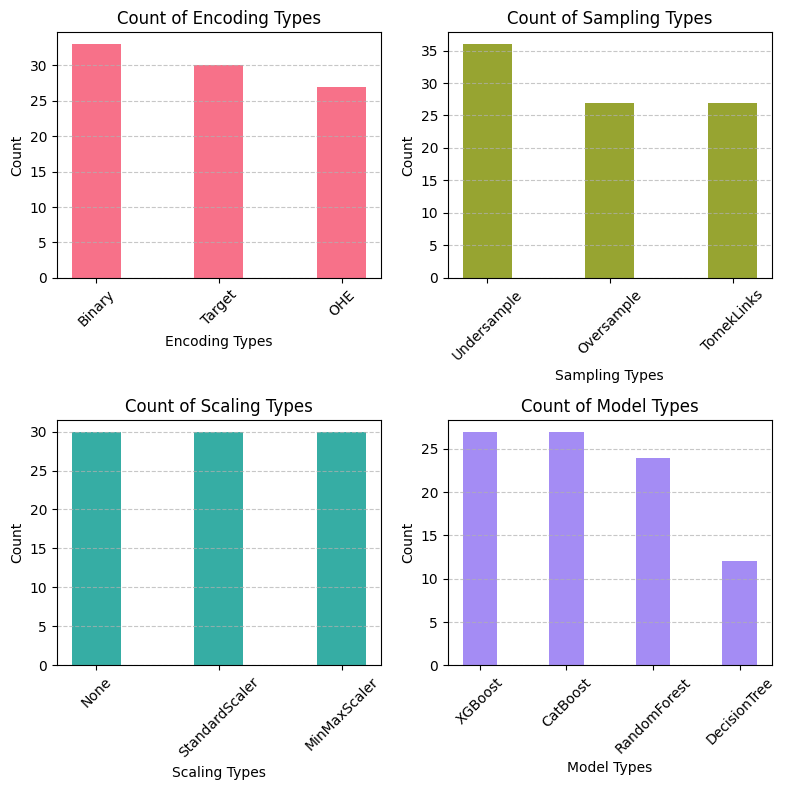

In [4]:
import seaborn as sns
features = ['Encoding', 'Sampling', 'Scaling', 'Model']

colors = sns.color_palette("husl", len(features))

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

for i, feature in enumerate(features):
    axs[i].bar(recall_results[feature].value_counts().index,
               recall_results[feature].value_counts(),
               color=colors[i],
               width=0.4)
    axs[i].set_title('Count of {} Types'.format(feature))
    axs[i].set_xlabel('{} Types'.format(feature))
    axs[i].set_ylabel('Count')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

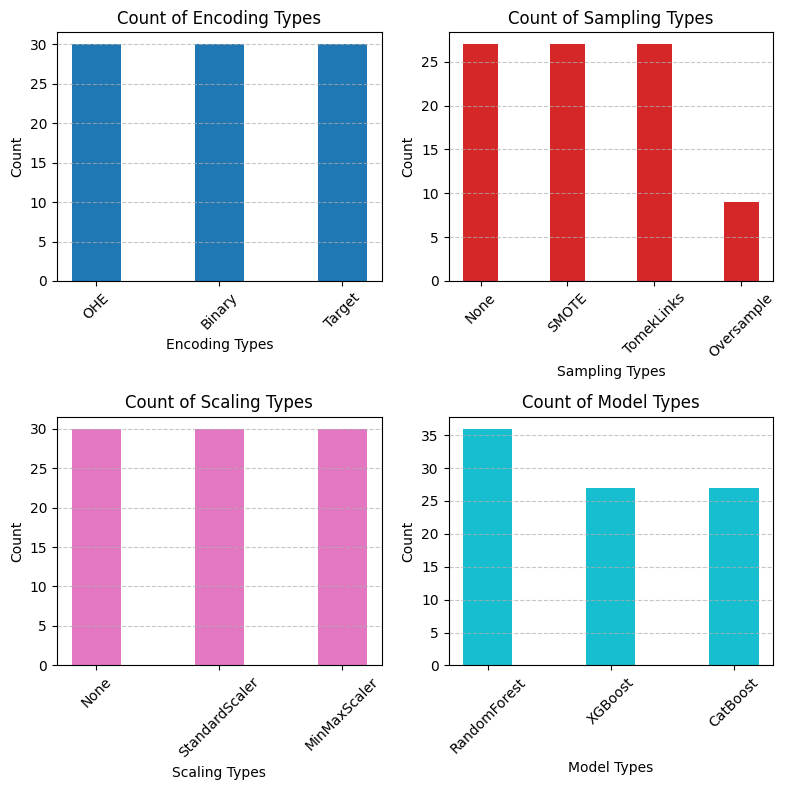

In [5]:
colors = plt.cm.tab10(np.linspace(0, 1, len(features)))

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

for i, feature in enumerate(features):
    axs[i].bar(precision_results[feature].value_counts().index,
               precision_results[feature].value_counts(),
               color=colors[i],
               width=0.4)
    axs[i].set_title('Count of {} Types'.format(feature))
    axs[i].set_xlabel('{} Types'.format(feature))
    axs[i].set_ylabel('Count')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

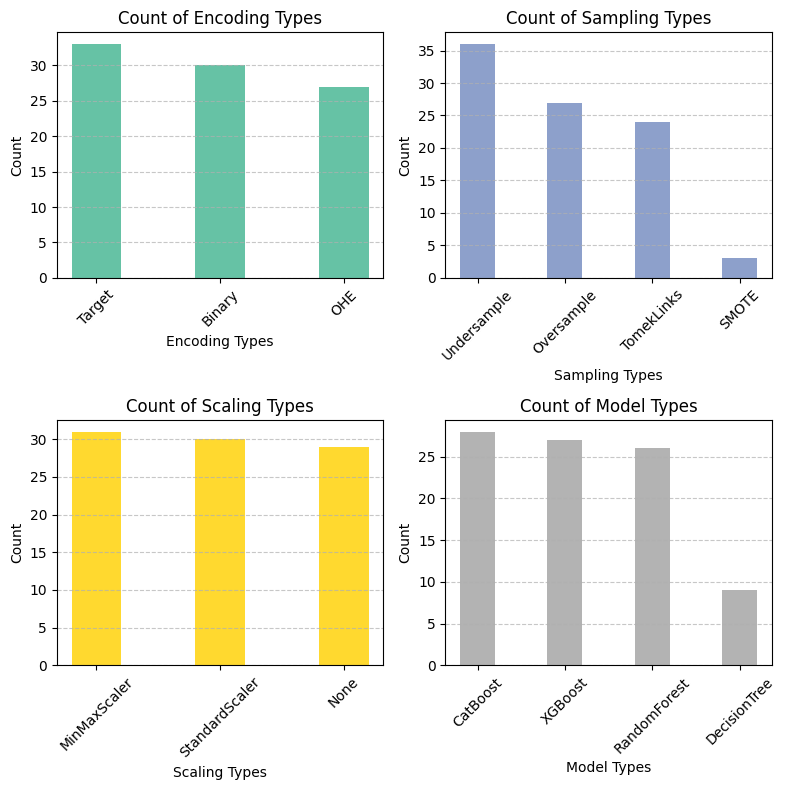

In [18]:
colors = plt.cm.Set2(np.linspace(0, 1, len(features)))

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

for i, feature in enumerate(features):
    axs[i].bar(auc_results[feature].value_counts().index,
               auc_results[feature].value_counts(),
               color=colors[i],
               width=0.4)
    axs[i].set_title('Count of {} Types'.format(feature))
    axs[i].set_xlabel('{} Types'.format(feature))
    axs[i].set_ylabel('Count')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

<ipython-input-20-f80ba0c26295>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_scores = results.groupby(['Model']).median()[['F1 Score Class 1', 'AUC Score']].reset_index()


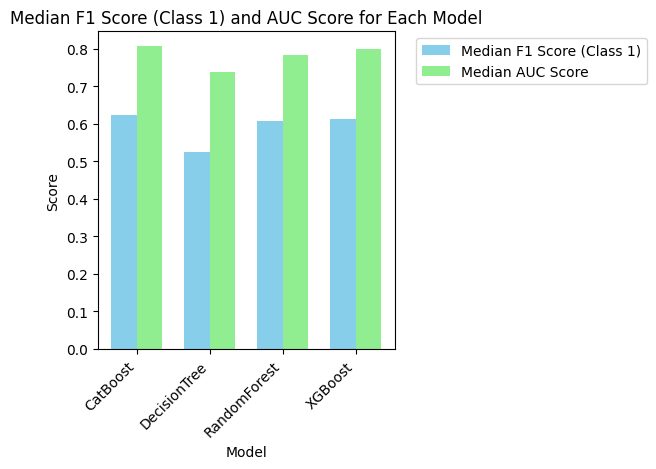

In [20]:
median_scores = results.groupby(['Model']).median()[['F1 Score Class 1', 'AUC Score']].reset_index()

plt.figure(figsize=(6.4, 4.8))
bar_width = 0.35
x = range(len(median_scores['Model']))

plt.bar(x, median_scores['F1 Score Class 1'], width=bar_width, color='skyblue', label='Median F1 Score (Class 1)')

plt.bar([i + bar_width for i in x], median_scores['AUC Score'], width=bar_width, color='lightgreen', label='Median AUC Score')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Median F1 Score (Class 1) and AUC Score for Each Model')
plt.xticks([i + bar_width/2 for i in x], median_scores['Model'], rotation=45, ha='right')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

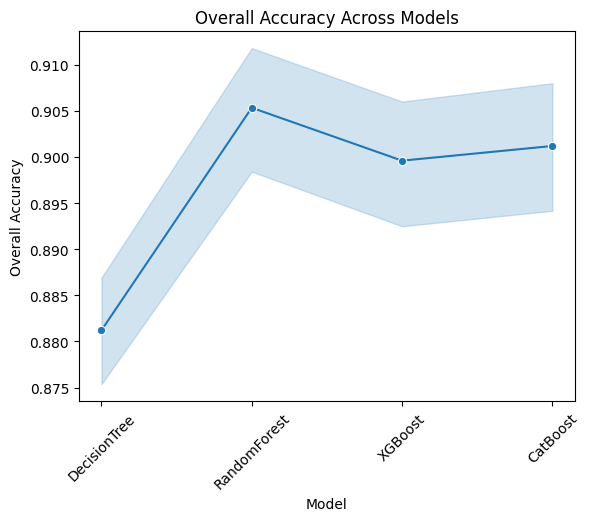

In [6]:
# Line Plot for Overall Accuracy
plt.figure(figsize=(6.4, 4.8))
sns.lineplot(x='Model', y='Overall Accuracy', data=results, marker='o')
plt.title('Overall Accuracy Across Models')
plt.xticks(rotation=45)
plt.show()